In [1]:
import ambulance_game as abg
import numpy as np
import math
import matplotlib.pyplot as plt
import functools
import sympy as sym

# Blocking time formula (recursive approach)
- **From steady state probabilities**
- **For class 2 patients (ambulance patients)**

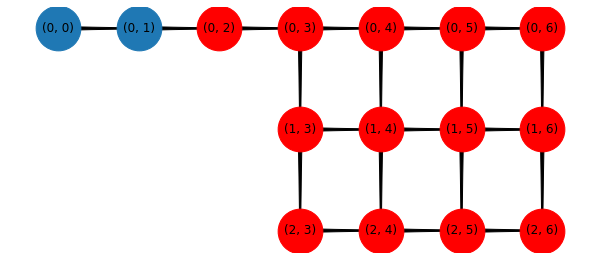

In [2]:
abg.markov.visualise_ambulance_markov_chain(2, 3, 6, 2)

## Blocking States
$$ S_b = \{ (u,v) \in S \; | \; u > 0 \} $$

In [3]:
def is_blocking_state(state):
    return state[0] > 0

## Accepting States
$$
S_A^A = 
\begin{cases}
\{(u,v) \in S \; | \; u < M \}  & \text{if } T \leq N\\
\{(u,v) \in S \; | \; v < N \}  & \text{otherwise}
\end{cases}
$$

In [4]:
def is_accepting_state(state, threshold, system_capacity, parking_capacity):
    condition = (
        (state[0] < parking_capacity)
        if (threshold <= system_capacity)
        else (state[1] < system_capacity)
    )
    return condition


def is_accepting_state_others(state, system_capacity):
    return state[1] < system_capacity

## Expected sojourn time in a state (ignoring any arrivals)
$$ 
c(u,v) = 
    \frac{1}{min(v,C) \mu}
$$

In [5]:
def expected_sojourn_time_in_markov_state(state, num_of_servers, mu):
    return 1 / (min(state[1], num_of_servers) * mu)

## Recursive blocking time for each state $(u,v)$
$$
b(u,v) = 
\begin{cases} 
    0, & \textbf{if } (u,v) \notin S_b \\
    c(u,v) + p_s b(u-1, v) + p_o b(u, v+1), & \textbf{if } u > 0 \textbf{ and } v = T \\
    c(u,v) + p_s b(u, v-1) + p_o b(u, v+1), & \textbf{otherwise} \\
\end{cases}
$$

$$
p_s = \frac{\mu}{\lambda^o + \mu} \\
p_o = \frac{\lambda^o}{\lambda^o + \mu}
$$

In [13]:
def prob_service(lambda_o, mu):
    return mu / (lambda_o   + mu)

def prob_other_arrival(lambda_o, mu):
    return lambda_o / (lambda_o + mu)

def get_recursive_blocking_time(
    state, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity
):

    if not is_blocking_state(state):
        return 0

    if state[0] >= 1 and state[1] == threshold:
        service_state = (state[0] - 1, state[1])
    else:
        service_state = (state[0], state[1] - 1)
    
    return "STUCK IN AN INFINITE RECURSION"

    others_arrival_state = (state[0], state[1] + 1) if state[1] < system_capacity else 0
    print(state)
    time_blocked = expected_sojourn_time_in_markov_state(
        state, num_of_servers, mu
    ) + prob_service(
        lambda_o, mu
    ) * get_recursive_blocking_time(
        service_state, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity
    ) + prob_other_arrival(
        lambda_o, mu
    ) * get_recursive_blocking_time(
        others_arrival_state, lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity
    )
    
    return time_blocked

# Closer look at the problem

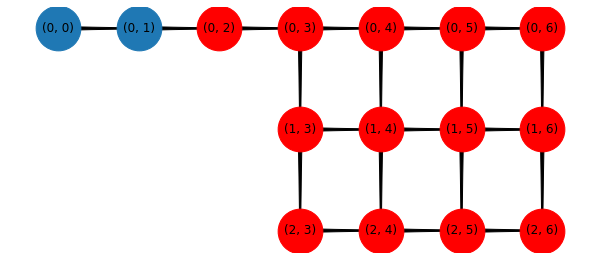

In [14]:
abg.markov.visualise_ambulance_markov_chain(2, 3, 6, 2)

## Recursive blocking time for each state $(u,v)$
$$
b(u,v) = 
\begin{cases} 
    0, & \textbf{if } (u,v) \notin S_b \\
    c(u,v) + p_s b(u-1, v) + p_o b(u, v+1), & \textbf{if } u > 0 \textbf{ and } v = T \\
    c(u,v) + p_s b(u, v-1) + p_o b(u, v+1), & \textbf{otherwise} \\
\end{cases}
$$

$$
p_s = \frac{\mu}{\lambda^o + \mu} \\
p_o = \frac{\lambda^o}{\lambda^o + \mu}
$$

$$
b(1,3) = c(1,3) + p_s b(0,3) + p_o b(1,4) \\
b(1,4) = c(1,4) + p_s b(1,3) + p_o b(1,5) \\
b(1,5) = c(1,5) + p_s b(1,4) + p_o b(1,6) \\
b(1,6) = c(1,6) + b(1,5)
$$

$$
b(2,3) = c(2,3) + p_s b(1,3) + p_o b(2,4) \\
b(2,4) = c(2,4) + p_s b(2,3) + p_o b(1,5) \\
b(2,5) = c(2,5) + p_s b(2,4) + p_o b(1,6) \\
b(2,6) = c(2,6) + b(2,5)
$$

# *Recursive approach may be more complex to model - different approach should be used*

In [9]:
lambda_a = 1
lambda_o = 1
mu = 2
num_of_servers = 2
threshold = 3
system_capacity = 6
parking_capacity = 2

In [10]:
prob_service(lambda_o, mu)

0.6666666666666666

In [11]:
prob_other_arrival(lambda_o, mu)

0.3333333333333333

In [12]:
get_recursive_blocking_time((1,3), lambda_o, mu, num_of_servers, threshold, system_capacity, parking_capacity)

'Stuck in an infinite loop'

## Mean blocking time
$$ B = \frac{\sum_{(u,v) \in S_A} \pi_{(u,v)} \; b(u,v)}{\sum_{(u,v) \in S_A} \pi_{(u,v)}} $$

In [18]:
def mean_blocking_time_formula(
    all_states,
    pi,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
):
    mean_blocking_time = 0
    prob_accept_ambulance = 0
    for u, v in all_states:
        if is_accepting_state((u, v), threshold, system_capacity, parking_capacity):
            arriving_state = (u + 1, v) if v >= threshold else (u, v + 1)
            current_state_block = get_recursive_blocking_time(
                arriving_state,
                lambda_o,
                mu,
                num_of_servers,
                threshold,
                system_capacity,
                parking_capacity,
            )
            mean_blocking_time += current_state_block * pi[u, v]
            prob_accept_ambulance += pi[u, v]
    
    # prob_accept_others = np.sum([pi[state] for state in all_states if is_accepting_state_others(state, system_capacity)])
    # others_rate = (prob_accept_others) / ((prob_accept_ambulance) + (prob_accept_others))
    # ambulance_rate = (prob_accept_ambulance) / ((prob_accept_ambulance) + (prob_accept_others))
    # return mean_blocking_time, prob_accept_ambulance, prob_accept_others, ambulance_rate, others_rate
    
    return mean_blocking_time / prob_accept_ambulance


# Comparing simulation and Markov chains

### 1. Function that gets blocking time from simulation (already calculated)
### 2. Function that calculates blocking time using state probabilities of Markov chains

In [19]:
def get_mean_blocking_time_markov(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
):
    transition_matrix = abg.markov.get_transition_matrix(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
    )
    pi = abg.markov.get_steady_state_algebraically(
        transition_matrix, algebraic_function=np.linalg.solve
    )
    all_states = abg.markov.build_states(threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity)
    state_probabilities = abg.markov.get_markov_state_probabilities(
        pi, all_states, output=np.ndarray
    )
    
    mean_blocking_time = mean_blocking_time_formula(
        all_states=all_states,
        pi=state_probabilities,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        parking_capacity=parking_capacity,
    )

    return mean_blocking_time


### 3. Function that calculates blocking time using state probability of simulation

In [20]:
def get_mean_blocking_time_simulation(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    seed_num=None,
    num_of_trials=10,
    runtime=2000
):
    state_probabilities = abg.simulation.get_average_simulated_state_probabilities(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
        seed_num=seed_num,
        num_of_trials=num_of_trials,
        runtime=runtime
    )

    all_states = [
        (u, v)
        for v in range(state_probabilities.shape[1])
        for u in range(state_probabilities.shape[0])
        if state_probabilities[u, v] > 0
    ]

    mean_blocking_time = mean_blocking_time_formula(
        all_states=all_states,
        pi=state_probabilities,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        parking_capacity=parking_capacity,
    )

    return mean_blocking_time


## Playing around

In [21]:
lambda_a = 1
lambda_o = 1
mu = 2
num_of_servers = 1
threshold = 1
system_capacity = 2
parking_capacity = 1

&lt;networkx.classes.digraph.DiGraph at 0x1f7356a2700&gt;

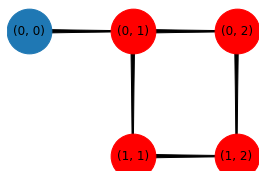

In [22]:
abg.markov.visualise_ambulance_markov_chain(num_of_servers, threshold, system_capacity, parking_capacity)

In [23]:
get_mean_blocking_time_simulation(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=0,
    num_of_trials=10,
    runtime=2000
)

0.3531281614188685

In [25]:
get_mean_blocking_time_markov(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity
)

0.35714285714285715

In [26]:
times = abg.simulation.get_multiple_runs_results(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            num_of_trials=10,
            seed_num=None,
            runtime=1000,
            patient_type="ambulance",
            warm_up_time=100
        )
simulation_blocking_times = [np.mean(b.blocking_times) for b in times]
np.mean(simulation_blocking_times)

0.5078234203227561

In [27]:
transition_matrix = abg.markov.get_transition_matrix(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
)
pi = abg.markov.get_steady_state_algebraically(
    transition_matrix, algebraic_function=np.linalg.solve
)
all_states = abg.markov.build_states(threshold=threshold, system_capacity=system_capacity, parking_capacity=parking_capacity)
state_probabilities = abg.markov.get_markov_state_probabilities(
    pi, all_states, output=np.ndarray
) 
state_probabilities

array([[0.28571429, 0.28571429, 0.0952381 ],
       [       nan, 0.19047619, 0.14285714]])

In [194]:
def get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    plot_over="lamda_a",
    max_parameter_value=1,
    accuracy=None,
):
    all_times_sim = []
    all_mean_times_sim = []
    all_mean_times_markov = []

    if accuracy == None or accuracy <= 1:
        accuracy = 5

    if plot_over == "lambda_a":
        range_space = np.linspace(lambda_a, max_parameter_value, accuracy)
    elif plot_over == "lambda_o":
        range_space = np.linspace(lambda_o, max_parameter_value, accuracy)
    elif plot_over == "mu":
        range_space = np.linspace(mu, max_parameter_value, accuracy)
    elif plot_over == "num_of_servers":
        range_space = np.linspace(num_of_servers, max_parameter_value, accuracy)
    elif plot_over == "threshold":
        range_space = np.linspace(threshold, max_parameter_value, accuracy)
    elif plot_over == "system_capacity":
        range_space = np.linspace(system_capacity, max_parameter_value, accuracy)
    elif plot_over == "parking_capacity":
        range_space = np.linspace(parking_capacity, max_parameter_value, accuracy)
    else:
        return "Arguement plot_over invalid"

    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_o = parameter
        elif plot_over == "mu":
            mu = parameter
        elif plot_over == "num_of_servers":
            num_of_servers = parameter
        elif plot_over == "threshold":
            threshold = parameter
        elif plot_over == "system_capacity":
            system_capacity = parameter
        elif plot_over == "parking_capacity":
            parking_capacity = parameter

        num_of_servers = int(num_of_servers)
        threshold = int(threshold)
        system_capacity = int(system_capacity)
        parking_capacity = int(parking_capacity)

        times = abg.simulation.get_multiple_runs_results(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            num_of_trials=num_of_trials,
            seed_num=seed_num,
            runtime=runtime,
            patient_type="both",
            warm_up_time=100
        )
        simulation_blocking_times = [np.mean(b.blocking_times) for b in times]
        mean_blocking_time_sim = get_mean_blocking_time_simulation(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            num_of_trials=num_of_trials,
            seed_num=seed_num,
            runtime=runtime
        )

        mean_blocking_time_markov = get_mean_blocking_time_markov(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity
        )

        all_times_sim.append(simulation_blocking_times)
        all_mean_times_sim.append(mean_blocking_time_sim)
        all_mean_times_markov.append(mean_blocking_time_markov)

    diff = (range_space[1] - range_space[0]) / 2

    plt.figure(figsize=(20, 10))
    plt.plot(range_space, all_mean_times_sim, label="Simulation State probabilities")
    plt.plot(range_space, all_mean_times_markov, label="Markov State probabilities")
    plt.violinplot(
        all_times_sim,
        positions=range_space,
        widths=diff,
        showmeans=True,
        showmedians=False,
    )
    title = (
        "lambda_a="
        + str(lambda_a)
        + ", lambda_o="
        + str(lambda_o)
        + ", mu="
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", T="
        + str(threshold)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(parking_capacity)
    )
    plt.title(title)
    plt.xlabel(plot_over)
    plt.ylabel("Blocking time")
    plt.legend()
    plt.show()
    return range_space, all_mean_times_sim, all_mean_times_markov, all_times_sim


# Plots

In [215]:
lambda_a = 1
lambda_o = 1
mu = 2
num_of_servers = 1
threshold = 1
system_capacity = 2
parking_capacity = 1

num_of_trials = 10
seed_num = None
runtime = 1000
accuracy = 5

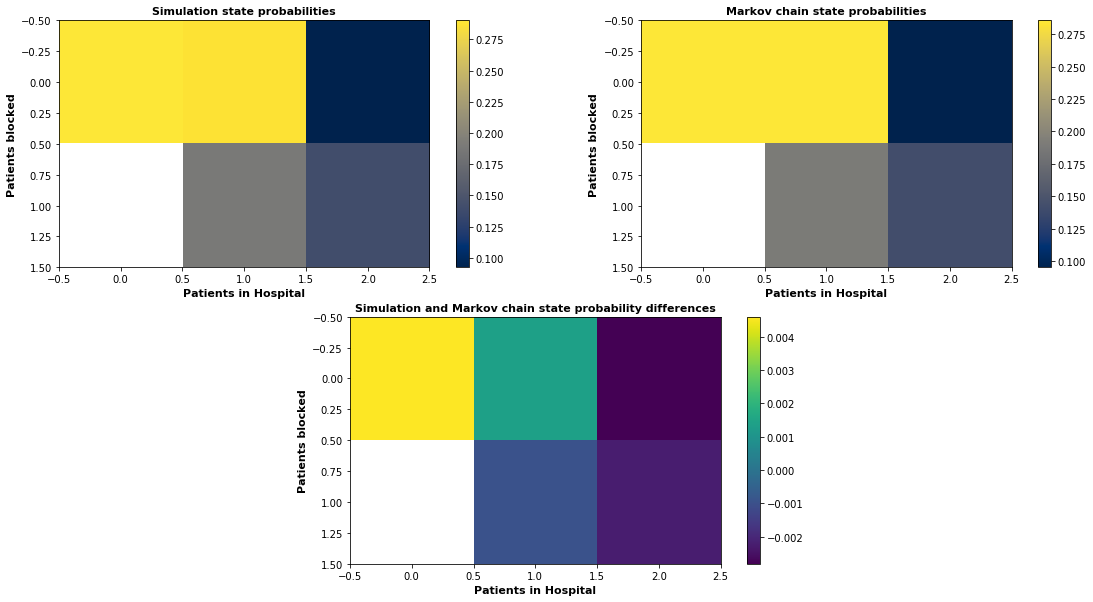

In [199]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


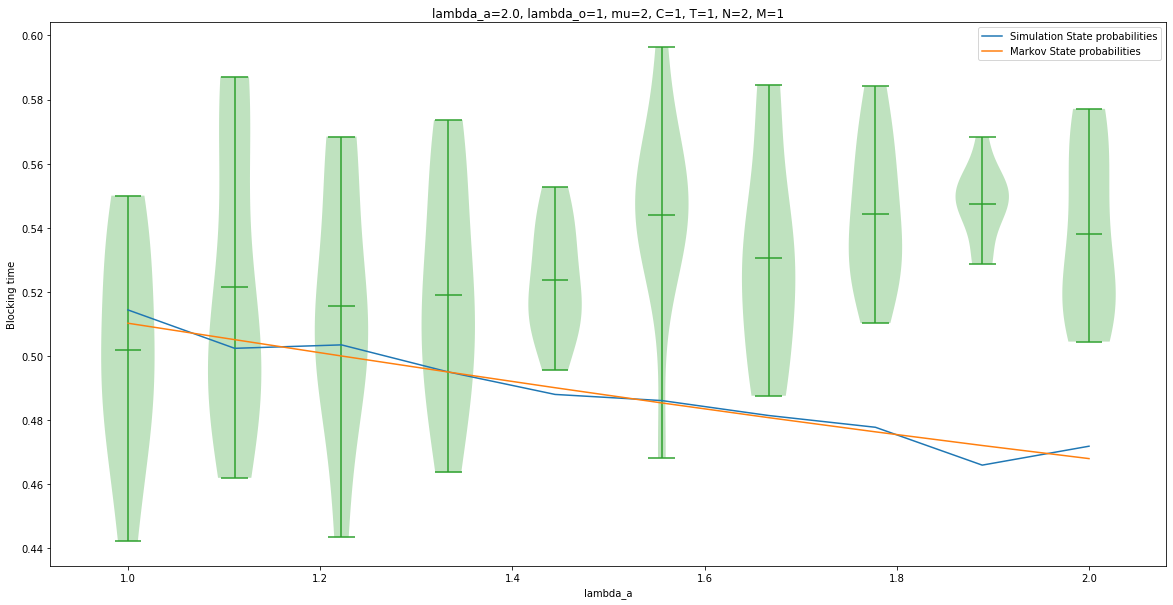

In [208]:
plot_over = "lambda_a"
max_parameter_value = 2
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)


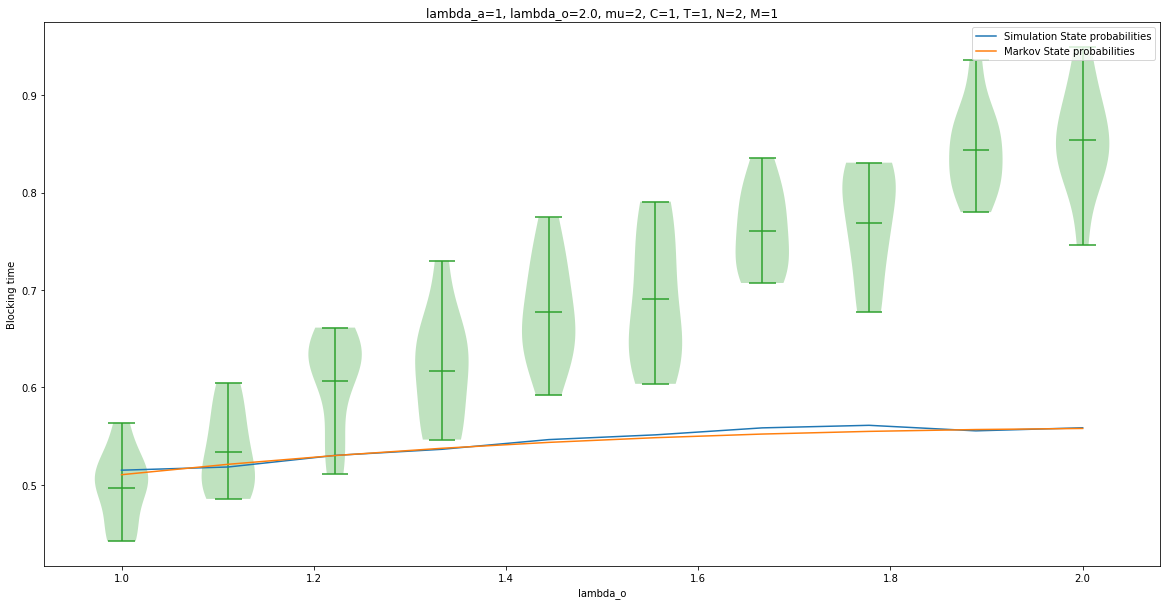

In [209]:
plot_over = "lambda_o"
max_parameter_value = 2
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

In [ ]:
plot_over = "mu"
max_parameter_value = 4
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

In [ ]:
plot_over = "num_of_servers"
max_parameter_value = 5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=5,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

In [ ]:
plot_over = "threshold"
max_parameter_value = 5
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

In [ ]:
plot_over = "system_capacity"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)

In [ ]:
plot_over = "parking_capacity"
max_parameter_value = 10
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over=plot_over,
    max_parameter_value=max_parameter_value,
    accuracy=accuracy,
)